# 1. CONTEXTUALIZANDO

In [1]:
#### Settings ###########
import seaborn as sns

sns.set()
import pandas as pd

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
import matplotlib.pyplot as plt

plt.style.use("classic")
plt.rcParams["figure.figsize"] = [10, 5]
%load_ext nb_black

<IPython.core.display.Javascript object>

Há um projeto no Datacamp chamado <b>Classify Song Genres from Audio Data</b>. Nele, construímos um modelo de árvore de decisão, com redução de dimensionalidade via PCA, para classificar estilos musicais. O projeto possui uma falha de Data Leakage e acredito que a estrutura possa ser melhorada com um Pipeline. Este notebook fará essas alterações para explorar um código melhor estruturado e um modelo com melhor acurácia.

Primeiro, o projeto rodou uma árvore de decisão e obteve acurácia de 86%. Em seguida, testou-se uma regressão logística, que atingiu 89%. Abaixo, o classification report dos dois modelos testados:
<img src='modelo_desbalanceado.png'>

Em seguida, construiu-se modelos com os dados balanceados. Nesse caso, a acurácia foi de 77% e 83%. O classification report:
<img src='modelo_balanceado.png'>

# 2. PRINCIPAL: MODELO UTILIZANDO PIPELINE E RANDOM FOREST

In [2]:
# Import libraries
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv("fma-rock-vs-hiphop.csv")

# Read in track metrics with the features
echonest_metrics = pd.read_json("echonest-metrics.json", precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(
    echonest_metrics, tracks[["track_id", "genre_top"]], on="track_id"
)

# Inspect the resultant dataframe
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


<IPython.core.display.Javascript object>

In [3]:
# Define our features
features = echo_tracks.drop(columns=["genre_top", "track_id"], axis=1)

# Define our labels
labels = echo_tracks["genre_top"]

<IPython.core.display.Javascript object>

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=0
)

<IPython.core.display.Javascript object>

In [18]:
# MODELO COM PIPELINE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Criando o Preprocessamento no Pipeline
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, X_train.columns)]
)

# Pipeline com random forest


rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)


# Fita o modelo
rf.fit(X_train, y_train)

# predicoes
y_pred = rf.predict(X_test)

# Acurácia do modelo
from sklearn.metrics import accuracy_score

print("Random Forest Accuracy: \n", accuracy_score(y_test, y_pred))

# Classification report
from sklearn.metrics import classification_report

class_rep_rf = classification_report(y_test, y_pred)

print("Random Forest: \n", class_rep_rf)

# Matriz de Confusao
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

Random Forest Accuracy: 
 0.9222761970853574
Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.75      0.79       279
        Rock       0.94      0.96      0.95      1162

    accuracy                           0.92      1441
   macro avg       0.89      0.86      0.87      1441
weighted avg       0.92      0.92      0.92      1441



array([[ 208,   71],
       [  41, 1121]])

<IPython.core.display.Javascript object>

E se tivéssemos colunas categóricas?

```python
# Criando o Preprocessamento no Pipeline
numeric_transformer = Pipeline(
    steps=[("median_imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[('freq_imputer', SimpleImputer(strategy='most_frequent')] 
)

# aplica transformador numerico nas colunas 0 e 1 e categorico nas 2 e 3
t = [('num', numeric_transformer, [0, 1]), ('cat', categorical_transformer, [2, 3])]
trasnformer = ColumnTransformer(transformers=t)

rf = Pipeline(
    steps=[("trasnformer", transformer), ("classifier", RandomForestClassifier())]
)

# Fita o modelo
rf.fit(X_train, y_train)

# predicoes
y_pred = rf.predict(X_test)
```

```python
# Avaliação com kfold
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Set up our K-fold cross-validation
kf = KFold(n_splits=10, random_state=10)

rf = RandomForestClassifier(random_state=10)

# Train our models using KFold cv
rf_score = cross_val_score(rf, X_train, y_train, cv=kf)

# Print the mean of each array of scores
print("Random Forest: ", np.mean(rf_score))
```

FEATURE IMPORTANCE

Feature ranking:
1. feature 5 (0.314431)
2. feature 1 (0.206537)
3. feature 3 (0.103631)
4. feature 6 (0.095354)
5. feature 0 (0.080388)
6. feature 2 (0.077559)
7. feature 7 (0.075699)
8. feature 4 (0.046402)


(-1, 8)

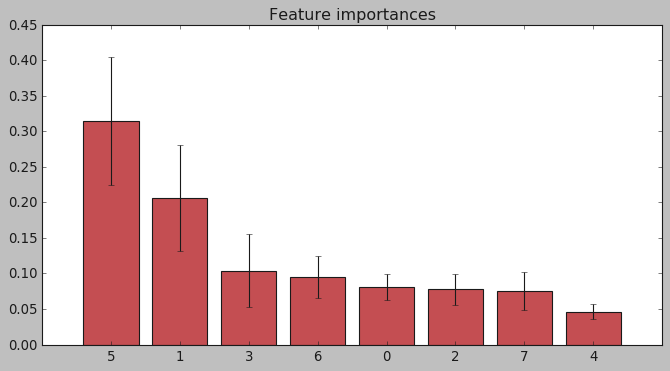

<IPython.core.display.Javascript object>

In [27]:
importances = rf.steps[1][1].feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.steps[1][1].estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(
    range(X_test.shape[1]),
    importances[indices],
    color="r",
    yerr=std[indices],
    align="center",
)
plt.xticks(range(X_test.shape[1]), indices)
plt.xlim([-1, X_test.shape[1]])

PERMUTATION IMPORTANCE

In [20]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0890 ± 0.0171,speechiness
0.0466 ± 0.0061,danceability
0.0223 ± 0.0022,acousticness
0.0193 ± 0.0054,tempo
0.0049 ± 0.0044,valence
0.0047 ± 0.0059,energy
0.0042 ± 0.0073,instrumentalness
-0.0014 ± 0.0044,liveness


<IPython.core.display.Javascript object>

PARTIAL DEPENDENCE PLOTS

(<Figure size 1200x760 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f956c057a90>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9572b7c510>})

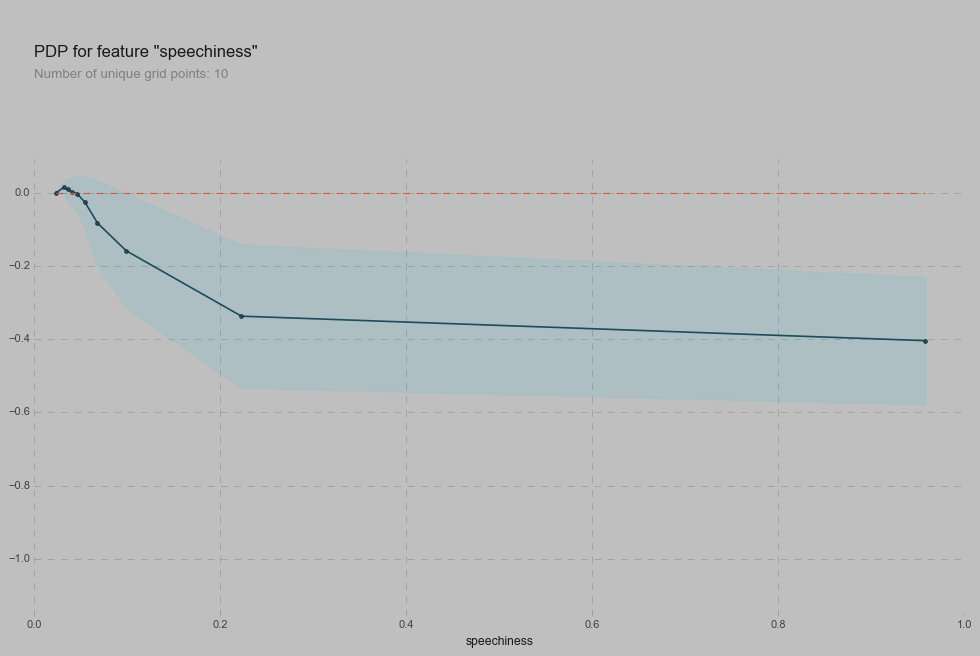

<IPython.core.display.Javascript object>

In [29]:
# Fontes:
# https://www.kaggle.com/dansbecker/partial-plots
# https://christophm.github.io/interpretable-ml-book/pdp.html

from pdpbox import pdp, get_dataset, info_plots


feature_to_plot = "speechiness"

pdp_dist = pdp.pdp_isolate(
    model=rf,
    dataset=X_test,
    model_features=features.columns.to_list(),
    feature=feature_to_plot,
)

pdp.pdp_plot(pdp_dist, feature_to_plot)

(<Figure size 1200x760 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9570c19990>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9553238110>})

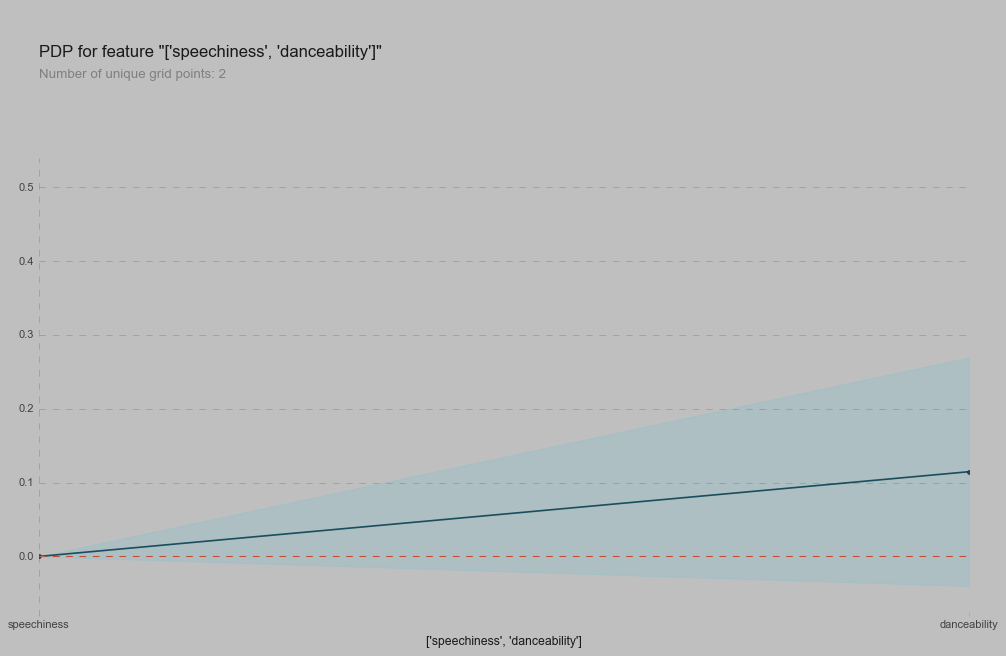

<IPython.core.display.Javascript object>

In [30]:
# Fontes:
# https://www.kaggle.com/dansbecker/partial-plots
# https://christophm.github.io/interpretable-ml-book/pdp.html

from pdpbox import pdp, get_dataset, info_plots


feature_to_plot = ["speechiness", "danceability"]

pdp_dist = pdp.pdp_isolate(
    model=rf,
    dataset=X_test,
    model_features=features.columns.to_list(),
    feature=feature_to_plot,
)

pdp.pdp_plot(pdp_dist, feature_to_plot)

ALTERNATIVA: USAR make_pipeline:

In [13]:
# EXEMPLO COM make_pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier


# Usaremos columntransformer mesmo nao precisando. Só para deixar o código já estruturado
num_transformator = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
t = [
    (
        "num",
        num_transformator,
        [
            "acousticness",
            "danceability",
            "energy",
            "instrumentalness",
            "liveness",
            "speechiness",
            "tempo",
            "valence",
        ],
    )
]

transformer = ColumnTransformer(transformers=t)

pipe2 = make_pipeline(transformer, RandomForestClassifier())

pipe2.fit(X_train, y_train)

# Fita o modelo
pipe2.fit(X_train, y_train)

# predicoes
y_pred = pipe2.predict(X_test)

# Acurácia do modelo
from sklearn.metrics import accuracy_score

print("Random Forest Accuracy: \n", accuracy_score(y_test, y_pred))

# Classification report
from sklearn.metrics import classification_report

class_rep_rf = classification_report(y_test, y_pred)

print("Random Forest: \n", class_rep_rf)

# Matriz de Confusao
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

<IPython.core.display.Javascript object>

O modelo foi bem melhor que o que foi feito no projeto. O único problema é que está errando  mais para o hip-hop. <br>
Uma alternativa é usar class weight ou alguma técnica de oversampling/undersampling.<br>
Veremos o que conseguimos fazer!

# 3. TENTATIVAS DE TRATAMENTO DO DESBALANCEAMENTO

## 3.1 CLASS_WEIGHT

A ideia do class weight é aplicar pesos diferentes para classes diferentes. Claro que não há uma resposta simples para qual peso aplicar. Normalmente o que eu faço é pegar a diferença entre as classes e testar valores nos entornos dela. Exemplo: imagine que a classe 1 é 4x maior que a classe 0. Então, podemos testar a classe 0 com valor 1 e testar alguns valores para a classe 1 em torno de 4 (tipo testar de 2 a 10, podendo até tentar decimais com o np.linspace). Algo que já vi fazerem foi testar valores i em np.linspace(), sendo que a classe 0 recebe i e a classe 1 recebe 1-i. Outra coisa que rola de fazer também é testar com "balanced", costuma dar bom também!

In [7]:
from sklearn.metrics import precision_recall_fscore_support as score


def trying_class_weight(class_weight):
    """ FUNÇÃO PARA TESTAR O RESULTADO DE DIFERENTES PESOS PARA AS CLASSES """
    # Criando o Preprocessamento no Pipeline
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[("num", numeric_transformer, X_train.columns)]
    )

    # Pipeline com random forest
    rf = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(class_weight=class_weight)),
        ]
    )

    # Fita o modelo
    rf.fit(X_train, y_train)

    # predicoes
    y_pred = rf.predict(X_test)

    # Matriz de Confusao
    cm = confusion_matrix(y_test, y_pred)
    accuracy = (cm[0, 0] + cm[1, 1]) / len(y_test)

    precision, recall, fscore, support = score(y_test, y_pred, average="macro")

    return accuracy, fscore

<IPython.core.display.Javascript object>

In [8]:
# Primeiro, algumas tentativas padrão:
accuracy, fscore = trying_class_weight("balanced")
print("For balanced:")
print(accuracy)
print(fscore)

accuracy, fscore = trying_class_weight(None)
print("For None:")
print(accuracy)
print(fscore)

accuracy, fscore = trying_class_weight({"Hip-Hop": 1, "Rock": 4})
print("For 1:4")
print(accuracy)
print(fscore)


For balanced:
0.9215822345593337
0.8656028775624576
For None:
0.9215822345593337
0.8672265180035502
For 1:4
0.919500346981263
0.8659061737902709


<IPython.core.display.Javascript object>

Balanced e None deram quase a mesma coisa, que bizarro. Pior, para 1:4 o modelo cagou mais ainda. Vamos fazer novas tentativas...

In [9]:
# Vamos testando alguns números entre 2 e 8 para rock (100 tentativas)
weights = []
accuracies = []
f1scores = []

# trying_class_weight é uma função que aplica o peso e ve acuracia e f1-score
for i in np.linspace(2, 8, 100):
    accuracy, fscore = trying_class_weight({"Hip-Hop": 1, "Rock": i})
    weights.append(i)
    accuracies.append(accuracy)
    f1scores.append(fscore) # será que dá para criar um dict aqui?

<IPython.core.display.Javascript object>

In [14]:
print(max(accuracies))
print(weights[accuracies.index(max(accuracies))])

0.926439972241499
6.606060606060606


<IPython.core.display.Javascript object>

Na melhor situação, que foi com 1:6.06, o ganho foi de menos de 0.5pp, muito pouco... #chateado

In [15]:
# Vamos de tentar isso aqui que achei pela internet e ainda não entendi bem a lógica matemática
weights = []
accuracies = []
f1scores = []
for i in np.linspace(0.0, 1, 100):
    accuracy, fscore = trying_class_weight({"Hip-Hop": i, "Rock": 1 - i})
    weights.append(i)
    accuracies.append(accuracy)
    f1scores.append(fscore)

/Users/andremota/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andremota/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

In [16]:
print(max(accuracies))
print(weights[accuracies.index(max(accuracies))])

0.9257460097154754
0.3434343434343435


<IPython.core.display.Javascript object>

Ainda tá meio merda. Vamos de SMOTE?

## 3.2 SMOTE

# 4. EXTRAS

## RANDOMIZED SEARCH

Vamos tunar os hiperparâmetros da Random Forest, mas com o Randomized porque o Grid vai levar a vida toda.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# best model
print(rf_random.best_params_)

In [ ]:
# MODELO COM PIPELINE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

# Criando o Preprocessamento no Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train.columns)])

# Pipeline com random forest
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators= 200,
                                                            min_samples_split=10,
                                                            min_samples_leaf= 1,
                                                            max_features='sqrt',
                                                            max_depth= 40,
                                                            bootstrap= False))])


# Fita o modelo
rf.fit(X_train, y_train)

# predicoes
y_pred = rf.predict(X_test)

# Acurácia do modelo
from sklearn.metrics import accuracy_score
print("Random Forest Accuracy: \n",accuracy_score(y_test, y_pred))

# Classification report
from sklearn.metrics import classification_report
class_rep_rf = classification_report(y_test, y_pred)

print("Random Forest: \n", class_rep_rf)

# Matriz de Confusao
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Veja que o modelo não melhorou, e piorou em alguns casos (f1-score)

## PIPELINE PARA SELEÇÃO DO MODELO

Antes de tentarmos melhorar o balanceamento, vamos só fazer uma brincadeirinha aqui e testar vários modelos com os parâmetros padrão mesmo e ver qual tem melhor resultado. Mera curiosidade.

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    SVC(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

for classifier in classifiers:
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
    pipe.fit(X_train, y_train)
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))